<a href="https://colab.research.google.com/github/CrisztinaZudor/BirdAudioDetection/blob/main/BirdAudioDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Bird Detection in Audio Recordings

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
langatfestus_bird_audio_detection_path = kagglehub.dataset_download('langatfestus/bird-audio-detection')

print('Data source import complete.')


100%|██████████| 10.3G/10.3G [02:05<00:00, 87.9MB/s]

Extracting files...


Data source import complete.


In [44]:
import pandas as pd # data processing, CSV file I/O (tabular data -> with a structure of rows and columns)
import librosa # for audio analysis and manipulation
import os

# Directory where the dataset is located
dataset_dir = '/root/.cache/kagglehub/datasets/langatfestus/bird-audio-detection/versions/3'

# Update the path to include the nested 'wav' directory
csv_file_path = os.path.join(dataset_dir, 'ff1010bird_metadata.csv')
wav_dir = os.path.join(dataset_dir, 'ff1010bird_wav', 'wav')  # Updated to include the nested 'wav' folder

# Load the CSV file
metadata = pd.read_csv(csv_file_path)
print(metadata.head())

# Ensure the column name for the audio file names is correct (assuming 'itemid' holds the filenames)
# and the filenames need the '.wav' extension if not already included
for index, row in metadata.iterrows():
    audio_file_name = f"{row['itemid']}.wav"  # Append '.wav' if the IDs don't already include it
    audio_path = os.path.join(wav_dir, audio_file_name)
    if os.path.exists(audio_path):
        audio, sr = librosa.load(audio_path, sr=None)  # Load the audio file
        # You can now process the 'audio' array with 'sr' as its sample rate
        # For example, feature extraction, visualization, etc.
    else:
        print(f"Audio file {audio_file_name} not found.")


   itemid  hasbird
0   64486        0
1    2525        0
2   44981        0
3  101323        0
4  165746        0


In [45]:
############## INITIAL SETTINGS:######################

import numpy as np # linear algebra operations
import matplotlib.pyplot as plt # for data visualization (charts, histograms...)
import seaborn as sns # for data visualization (more professional, especially in combination with pandas)

In [46]:
df = pd.read_csv(csv_file_path) # reads data from a CSV file and puts it into a DataFrame object
print(f'Number of elements: {df.shape[0]}') # prints the number of rows ()
# shape - returns both the number of rows and the number of columns, shape[0] - returns only the number of rows
df.head(15) # displays the first n rows of df (n - by default=5)
# => df = key data structure that stores the data extracted from the CSV and allows various analyses to be performed on it

Number of elements: 7690


,itemid,hasbird
0,64486,0
1,2525,0
2,44981,0
3,101323,0
4,165746,0
5,38232,0
6,104540,0
7,157473,0
8,132129,0
9,127302,0


In [47]:
################# PLAYING AND VISUALIZING DATA ##################

# Viewing the number of 'hasbird' labels
print('Number of audio files that contain bird sounds: {}'.format(df[df['hasbird'] == 1].shape[0]))
print('Number of audio files that do not contain bird sounds: {}'.format(df[df['hasbird'] == 0].shape[0]))

Number of audio files that contain bird sounds: 1935
Number of audio files that do not contain bird sounds: 5755


## Loading some audio files

In [48]:
# Playing an audio file
import IPython.display as ipd # a way to interact directly with audio files in IPython notebooks
#filepath = "ff1010bird_wav/wav/81068.wav" # path to an audio file in the dataset
dataset_dir = '/root/.cache/kagglehub/datasets/langatfestus/bird-audio-detection/versions/3'
filepath = os.path.join(dataset_dir, "ff1010bird_wav", "wav", "71838.wav")
ipd.Audio(filepath) # plays the audio file found at filepath
# 71838 -> bird
# 81068 -> !bird (not a bird)


In [49]:
# Defining a function to check the label of the audio file
def check_label(filepath):
  # Extracting the file number (from the dataset) => file_num
    file_num = int(filepath.split('/')[-1].split('.')[0])
    # Example: filepath = "/kaggle/input/bird-audio-detection/ff1010bird_wav/wav/92992.wav"
    # Split the path by the "/" symbol. Example: ['kaggle', 'input', 'bird-audio-detection', 'ff1010bird_wav', 'wav', '92992.wav']
    # Take the last element from the previous split. Example: '92992.wav'
    # Split again by the "." symbol. Example: ['92992', 'wav']
    # Extract the first element. Example: '92992'

    # Extracting the file's label => file_label
    file_label = df[df['itemid'] == file_num].hasbird.values[0]
    # Look up in the dataset for the audio file with the specified number
    # Select only the hasbird column
    # Select the first value from the column (audio file label)

# file_label is converted to text
    if file_label == 1:
        file_label = 'Bird detected'
    else:
        file_label = 'No bird detected'
    file_label
    return file_label

# Calling the function
check_label(filepath)

'Bird detected'

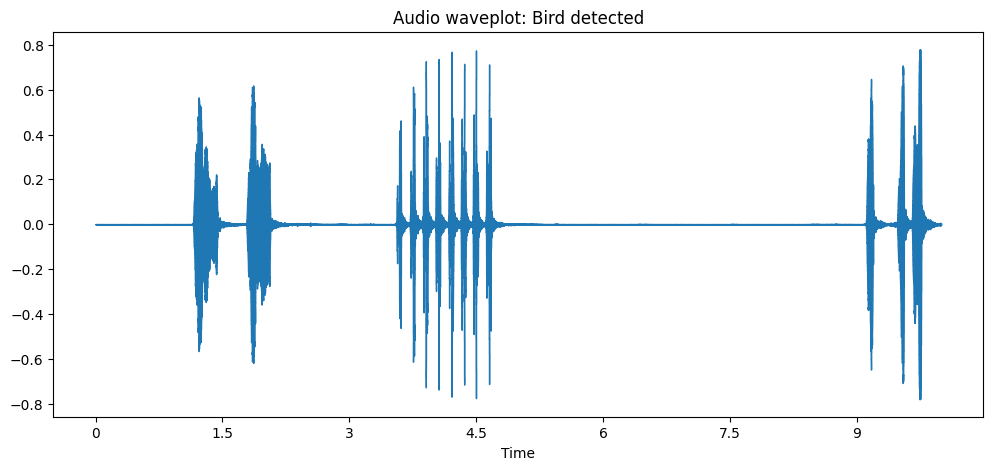

In [50]:
# Visualizing audio waveform
import librosa # for audio analysis and manipulation
import librosa.display # for displaying audio data

dataset_dir = '/root/.cache/kagglehub/datasets/langatfestus/bird-audio-detection/versions/3'
filepath = os.path.join(dataset_dir, "ff1010bird_wav", "wav", "71838.wav")# path to an audio file in the dataset
# 71838 -> bird
# 81068 -> !bird (not a bird)
data, sample_rate = librosa.load(filepath)
# => data - signal amplitude
# => sample_rate - sampling rate (number of samples collected per second)
file_label = check_label(filepath)
plt.figure(figsize=(12, 5))
plt.title(f'Audio waveplot: {file_label}')
librosa.display.waveshow(data, sr=sample_rate) # creates a waveform graphic representation
# horizontal axis -> time
# vertical axis -> amplitude

# **Data Preprocessing**

## Spectograms

In [51]:
# Spectrograms
dataset_dir = '/root/.cache/kagglehub/datasets/langatfestus/bird-audio-detection/versions/3'
filepath = os.path.join(dataset_dir, "ff1010bird_wav", "wav", "71838.wav")# path to an audio file in the dataset
# 71838 -> bird
# 81068 -> !bird (not a bird)
data1, sample_rate1 = librosa.load(filepath)

Text(0.5, 1.0, 'Spectrogram: Bird detected')

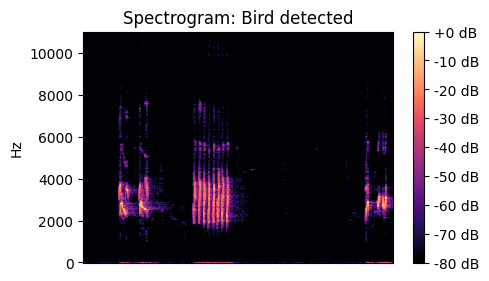

In [52]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(data1)), ref=np.max)
file_label = check_label(filepath)
# Calculate STFT (Short-Time Fourier Transform) => decomposes the signal into frequency and time components
# Calculate the modulus of each element in the matrix resulting from the STFT
# Convert the previously obtained spectral magnitude into dB
# => D - the audio spectrum of the signal data1 in dB (matrix)
plt.figure(figsize=(5, 3))
librosa.display.specshow(D, y_axis='linear') # creates a spectrogram graphic representation
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram: {file_label}')
# horizontal axis -> time
# vertical axis -> frequency
# color -> energy (dB)

## Extracting MFCCs

In [53]:
####################### MFCC PARAMETER EXTRACTION ##########################

dataset_dir = '/root/.cache/kagglehub/datasets/langatfestus/bird-audio-detection/versions/3'
filepath = os.path.join(dataset_dir, "ff1010bird_wav", "wav", "71838.wav")# path to an audio file in the dataset
# 71838 -> bird
# 81068 -> !bird (not a bird)
data, sample_rate = librosa.load(filepath)
#print(sample_rate) => 22050
#print(len(data)) => 220500
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
# y - input signal
# sr - sampling rate
# n_mfcc - number of desired coefficients
# => mfcc - two-dimensional matrix
# first dimension: coefficients calculated for each frame
# second dimension: frames from which coefficients were extracted
# Default values: window_length=2048, hop_length=512
# Number of frames: N = floor((len(data) - window_length) / hop_length) + 1 => 427
# => the signal was divided into 427 time frames, and from each frame, 40 MFCC coefficients were extracted
# ? why does the output = 431 frames? ?
print(mfccs.shape)
#print(mfccs)

(40, 431)


In [54]:
np.mean(mfccs.T, axis=0) # .T => transpose (columns <=> rows)
# => a vector that contains the average MFCC values for each coefficient across all time frames
# => average representation of the MFCC features of the entire audio signal

array([-5.2154694e+02, -1.5200009e+01, -3.3957573e+01,  3.1200214e+01,
        8.4018230e+00, -1.6708794e+01,  6.8149538e+00,  1.3579228e+01,
       -4.1106944e+00, -7.7423269e-01,  4.1016207e+00,  1.0904918e+00,
        3.0706711e+00,  8.0671537e-01,  1.8778390e+00,  4.0552063e+00,
        3.5596702e-03,  1.8460269e+00,  3.1918483e+00, -1.7971468e+00,
        4.1393304e+00,  2.7089455e+00,  7.8067535e-01,  2.7727728e+00,
        1.9014899e+00,  2.0216708e+00,  5.3424728e-01,  3.7874846e+00,
        1.7011597e+00,  1.2397813e+00,  3.5625243e+00,  1.2727504e+00,
        2.6136992e+00,  2.2841008e+00,  4.2964602e-01,  2.1770301e+00,
        2.3048606e+00,  2.1398177e+00,  1.7617979e+00,  9.0113068e-01],
      dtype=float32)

In [55]:
np.mean(mfccs.T,axis=0).shape

(40,)

In [56]:
# Defining a function to extract mfcc coefficients from the audio signal
def extract_mfcc_features(filename):
    # Extracting in data1 - the amplitude of the audio signal and in sample_rate1 - the sampling frequency of the audio signal
    data1, sample_rate1 = librosa.load(filename)
    # Extracting the mfcc coefficients
    mfccs_features = librosa.feature.mfcc(y=data1, sr=sample_rate1, n_mfcc=40)
    # Extracting the average of the MFCC coefficients, for scaling
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [57]:
# Vectors for storing features and labels
features = []
labels = []

# Walk through the audio files directory
for dirname, _, filenames in os.walk(audio_dir):
    for filename in filenames:
        my_filename = os.path.join(dirname, filename)
        if my_filename.endswith('.wav'):  # Ensure it's a WAV file
            mfccs_scaled_features = extract_mfcc_features(my_filename)
            features.append(mfccs_scaled_features)
            file_label = check_label(my_filename)
            labels.append(file_label)


In [58]:
# Check if the MFCC coefficients and labels have been extracted from all elements in the dataset
print(f'Num Features: {len(features)}')
print(f'Num Labels: {len(labels)}')

Num Features: 7690
Num Labels: 7690


In [59]:
# Creating a DataFrame that contains the MFCC coefficients and the label of each audio signal
df = pd.DataFrame({'MFCCs': features,
                  'labels': labels})
#df.head()

## Dealing with Class Imbalance

In [60]:
################## MANAGING CLASS IMBALANCE (OPTIONAL => accuracy 69%) ####################

# Count of labels in each class
df['labels'].value_counts()

,count
labels,
No bird detected,5755
Bird detected,1935


Text(0.5, 1.0, 'Number of labels in each class')

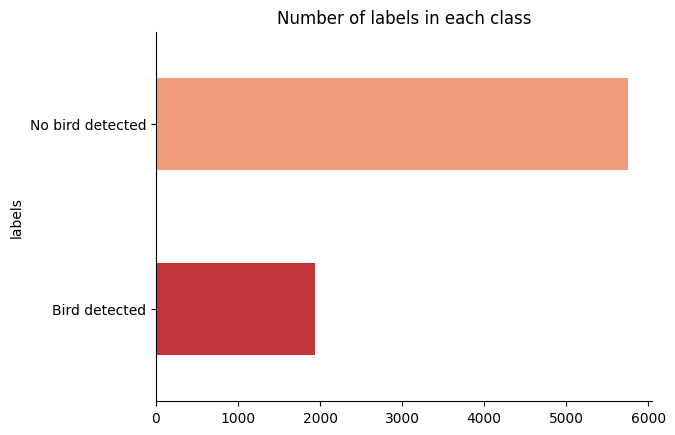

In [61]:
# Distribution of label counts between the two classes
df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('RdGy'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Number of labels in each class')
# => the classes are not balanced
# => balance them by reducing the number of labels (samples) from the majority class

- There is class imbalance as the number of samples in the 'No Bird' class is greater than those in the 'Has Bird' class. We therefore need to downsample the 'No Bird' class

In [62]:
# Identify the minority and majority classes
majority_class = df['labels'].value_counts().idxmax()
minority_class = df['labels'].value_counts().idxmin()
print(f'Majority Class: {majority_class}')
print(f'Minority Class: {minority_class}')

Majority Class: No bird detected
Minority Class: Bird detected


In [63]:
# Number of labels to be contained in the majority class
#samples_to_remove = len(df[df['labels'] == minority_class]) # equalize the number in each class => accuracy ~60%
samples_to_remove = len(df[df['labels'] == majority_class]) # no change => accuracy ~78%

In [64]:
# Applying the downsampling operation (equal number of labels in both classes)
df_downsampled = df[df['labels'] == majority_class].sample(n=samples_to_remove, replace=False)
# replace=False => no duplicates

In [65]:
# Concatenating the reduced majority class with the minority class
df_balanced1 = pd.concat([df_downsampled, df[df['labels'] == minority_class]])
#df_balanced1.head(10)
#df_balanced1.tail(10)
# => half of df_balanced will have one label and the other half will have another label
# => needs to be shuffled
df_balanced = df_balanced1.sample(frac=1, replace=False)
df_balanced.head(20)

,MFCCs,labels
277,"[-374.9877, 138.12878, -5.3886247, 11.615987, ...",No bird detected
2981,"[-135.41324, 23.308401, -54.114216, 30.888134,...",No bird detected
5825,"[-161.56863, 67.4442, -36.118774, 43.5304, -19...",No bird detected
5840,"[-123.14679, 148.03241, -20.742485, 11.135357,...",Bird detected
7124,"[-222.75906, 141.41956, -5.4263988, 34.20979, ...",No bird detected
1781,"[-18.176079, 86.16873, -20.51026, 9.659398, -1...",No bird detected
5504,"[-167.22012, 175.00511, -2.8980482, 42.388237,...",No bird detected
820,"[-223.67514, 73.33609, -28.410414, 31.707466, ...",Bird detected
5939,"[-104.44115, 71.20593, -0.6385286, 2.2723725, ...",No bird detected
4530,"[-50.847157, 109.449715, -16.891954, -5.379620...",No bird detected


In [66]:
df_balanced['labels'].value_counts()

,count
labels,
No bird detected,5755
Bird detected,1935


Text(0.5, 1.0, 'Number of labels in each class')

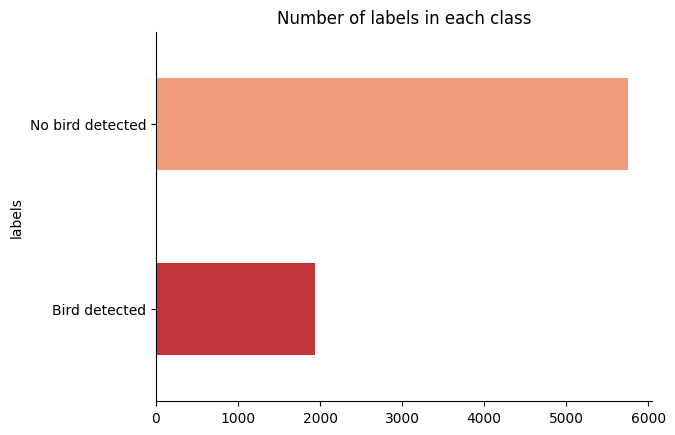

In [67]:
# Distribution of the number of labels between the two classes
df_balanced.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('RdGy'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Number of labels in each class')
# => balanced class

- Class Balance has now been achieved

## X-Y Split

In [68]:
############################ X-Y SPLIT ##############################

x = np.array(df_balanced['MFCCs'].tolist()) # x -> only the MFCC coefficients
# .tolist() - converts a vector into a list
y = df_balanced['labels'] # y -> only the labels
print(x.shape) # => MFCC coefficients from all samples (1935*2 = 3870)
print(y.shape) # => Labels from all samples (1935*2 = 3870)

(7690, 40)
(7690,)


## One-Hot Encoding of Y

In [69]:
# Converting y into a binary vector: Bird detected = [0,1] and No bird detected = [1,0]
from sklearn.preprocessing import LabelEncoder # to assign a value to each label
from tensorflow.keras.utils import to_categorical # to implement the One-Hot Encoding technique
labelencoder = LabelEncoder()

In [70]:
y.shape

(7690,)

In [71]:
y = to_categorical(labelencoder.fit_transform(y)) # actual conversion of the categorical variable into a One-Hot Encoding matrix
y[:5] # View the first 5 samples

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [72]:
y.shape

(7690, 2)

## Train-Test Split

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) # Splitting the samples
# => 80% of the samples for training and 20% for testing
# random_state -> randomizes (default = 0)

In [74]:
print(X_train.shape)
print(X_test.shape)

(6152, 40)
(1538, 40)


In [75]:
# Reshaping the parameters to be compatible with CNN input
#X_train = X_train.reshape(3096, 10, 4, 1)
#X_test = X_test.reshape(774, 10, 4, 1)
X_train = X_train.reshape(6152, 10, 4, 1)
X_test = X_test.reshape(1538, 10, 4, 1)

In [77]:
# The CNN expects input data with 10 channels, a height of 4, and a width of 1
input_dim = (10, 4, 1)

# **CNN Model**

## Model Training

In [79]:
import tensorflow as tf # for training deep learning models
from tensorflow.keras.models import Sequential # for working with layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout

# Conv2D - feature extraction, analysis, and a wide range of applications
        # - takes 3D or 4D input
        # - applies 2D filters (kernels - to identify, recognize, classify)
# Flatten - transforms 2D representations into 1D
         # - prepares the data for the next layers
# Dense - learns complex data relationships (classification)
# MaxPool2D - applies a filter of a specific size (pooling window) that slides over the input
           # - downsampling: within each window, MaxPool2D selects the maximum value
           # - the output is a new 3D tensor with reduced dimensions compared to the input
# Dropout - regularization technique
         # - prevents overfitting (when a model fits the training data too well and fails to generalize)
         # - randomly disables neurons at each iteration

In [80]:
model = Sequential() # creating the model
# adding layers to the model
model.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=input_dim))
# Conv2D - 64 filters, filter size = 3 by 3
# same - keeps spatial dimensions (adds zero padding)
# relu - (Rectified Linear Unit) sets negative values to zero and keeps positive values unchanged {f(x) = max(0, x)}
# input_dim - input with 10 channels, height of 4, and width of 1
model.add(MaxPool2D(pool_size=(2, 2)))
# pooling window size: 2 by 2
model.add(Conv2D(128, (3, 3), padding="same", activation="relu")) # same, but with 128 filters
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1)) # 10% of the neurons will be deactivated at each training pass
model.add(Flatten()) # convert to 1D
model.add(Dense(1024, activation="relu"))
# 1024 - number of neurons (each neuron in this layer will be connected to all neurons in the previous layer)
# relu - sets negative values to zero and keeps positive values unchanged
model.add(Dense(2, activation="softmax"))
# forces the output neuron values to be between zero and one

# Repeating Conv2D layers with an increasing number of filters (64 -> 128) allows the network to extract features at different complexity levels
# 3x3 window size - commonly used (balances feature extraction capability)
# Repeating MaxPool2D - significantly reduces spatial dimensions, allowing the network to focus on the most relevant features
# Dense layers combine the extracted features, reducing them to a final vector for classification

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model.summary() # show the model configuration

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 10, 4, 64)           │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 5, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 5, 2, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 339,714 (1.30 MB)

 Trainable params: 339,714 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

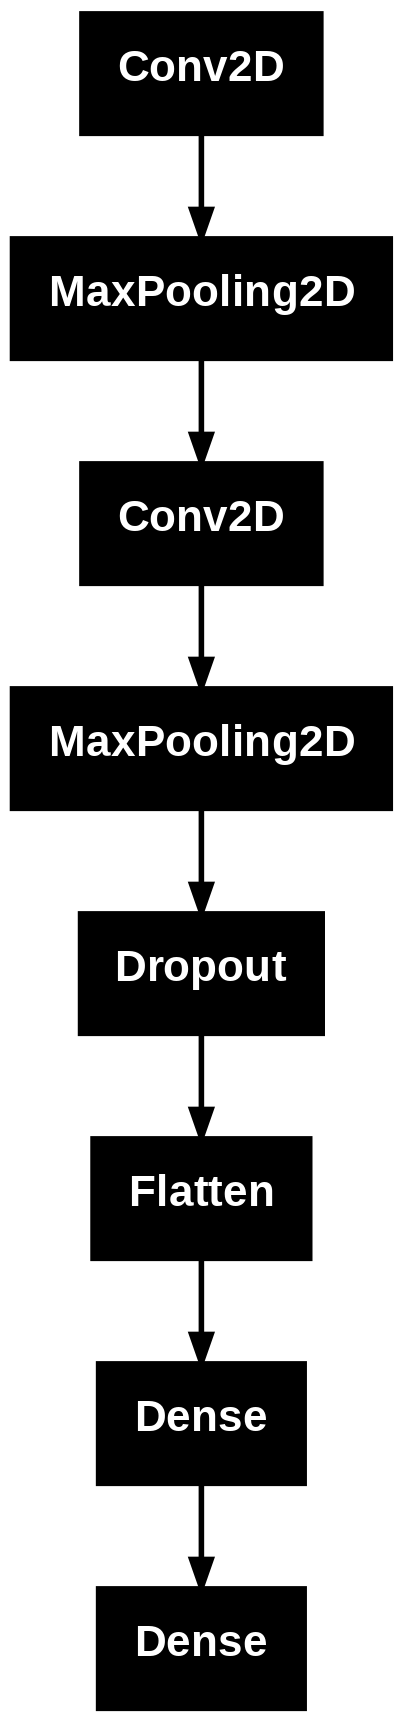

In [82]:
# Visualizing the model architecture
import pydot
tf.keras.utils.plot_model(model)

In [83]:
# An Adam optimizer is created (stochastic)
# Adam - an efficient optimization algorithm that updates the network parameters during training to minimize a loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# learning_rate - how much the network parameters are adjusted at each training iteration
# default = 0.001 (previous = 0.00001)

In [84]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# categorical_crossentropy - measures the difference between the probability distribution predicted by the model and the actual probability distribution of the target class
# accuracy - calculates the proportion of correct predictions made by the model out of the total number of predictions

In [85]:
# We create a ModelCheckpoint – useful for error recovery, monitoring progress, and flexibility for fine-tuning
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_acc', save_best_only=True)
# filepath - specifies the path and filename where the checkpoints will be saved
          # - indicates that the file will be named "best_model.h5" and saved in the current working directory
# monitor='val_acc' - the validation accuracy will be monitored
# save_best_only=True - only the best model will be saved

In [86]:
# The main call of the function that initiates the training process (fit)
history = model.fit(X_train, y_train, epochs=50, batch_size=50, validation_data=(X_test, y_test))
# X_train - the input data points that the model will use for learning during training
# y_train - the desired output for each data point in X_train
# epochs = 50 - each epoch represents one full iteration over the training data
# batch_size = 50 - the number of data samples processed together during a single training update
# validation_data = (X_test, y_test) - specifies a separate dataset for validation purposes (optional parameter)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6794 - loss: 1.3351 - val_accuracy: 0.7581 - val_loss: 0.6996
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7559 - loss: 0.5771 - val_accuracy: 0.7627 - val_loss: 0.5260
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7859 - loss: 0.4984 - val_accuracy: 0.7932 - val_loss: 0.4791
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7849 - loss: 0.4858 - val_accuracy: 0.7854 - val_loss: 0.4960
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7948 - loss: 0.4864 - val_accuracy: 0.7679 - val_loss: 0.5008
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7719 - loss: 0.5046 - val_accuracy: 0.7978 - val_loss: 0.4708
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7841 - loss: 0.4865 - val_accuracy: 0.7926 - val_loss: 0.4769
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7985 - loss: 0.4688 - val_accu

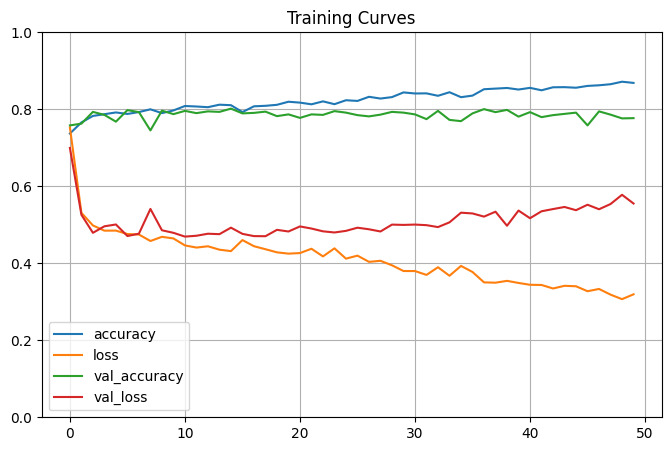

In [87]:
#Plotting the loss curves
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title('Training Curves')
plt.show()

## Evaluating Model Perfomance

In [88]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, y_test)
print(score)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7778 - loss: 0.5628
[0.5552424192428589, 0.7769830822944641]


In [89]:
preds = np.argmax(predictions, axis = 1)
y1 = np.argmax(y_test, axis = 1)
preds

array([1, 1, 0, ..., 1, 1, 1])

## Making Predictions with the Model

In [90]:
def classify_audio(filename):
    #preprocess the audio file
    audio, sample_rate = librosa.load(filename)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    #Reshape MFCC feature to 2-D array
    mfccs_scaled_features=mfccs_scaled_features.reshape(1, 10, 4, 1)
    #predicted_label=model.predict_classes(mfccs_scaled_features)
    x_predict=model.predict(mfccs_scaled_features)
    predicted_label=np.argmax(x_predict,axis=1)
    #print(predicted_label)
    prediction_class = labelencoder.inverse_transform(predicted_label) [0]
    if prediction_class == 'Oxpecker':
        print(f'Prediction Probability: {x_predict[0][0]}')
    else:
        print(f'Prediction Probability: {x_predict[0][1]}')
    print(f'Predicted Class: {prediction_class}')

In [100]:
dataset_dir = '/root/.cache/kagglehub/datasets/langatfestus/bird-audio-detection/versions/3'
filepath = os.path.join(dataset_dir, "ff1010bird_wav", "wav", "100.wav")# path to an audio file in the dataset

classify_audio(filepath)

ipd.Audio(filepath) # plays the audio file found at filepath

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction Probability: 0.24806341528892517
Predicted Class: Bird detected


## Saving the Model

In [101]:
#Saving to h5
model.save("Bird_Detector.h5")

In [102]:
#Converting to tflite
model = tf.keras.models.load_model('Bird_Detector.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpku1db79z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 4, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135078539918416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135078539905168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135078539916688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135078539915536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135078539905936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135078539915152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135078539915728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135078539917456: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [103]:
with open('Bird_Detector.tflite', 'wb') as f:
    f.write(tflite_model)